In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pycuda.autoinit
import pycuda.driver as cuda
import numpy

from pycuda.compiler import SourceModule
import numpy as np
from pycuda.gpuarray import vec
from pycuda import gpuarray
import pandas as pd

In [4]:
from IPython.display import Markdown

In [7]:
def display_cpp(code):
    return Markdown('```c++\n'+code+'```')

In [9]:
with open('../kernels/multichannel.cu','r') as fh:
    source_code = fh.read()
display_cpp(source_code)

```c++
#include <stdio.h>

__global__ void cycfold_multichannel(const float2 *pol0, const float2 *pol1,
        const double *phase, const double *step,
        const int fftlen, const int overlap, const int nbin, const int nlag,
        const int num_fft,
        float2 *xx, float2 *yy, float2 *xy, unsigned *hits) {

	// Lag is specified with threadIdx.x and blockIdx.x since there could be
	// more lags than allowed threads.
    const int ilaga = threadIdx.x;
    const int nlaga = blockDim.x;
    const int ilagb = blockIdx.x;
    const int ilag = ilagb*nlaga + ilaga;
    // Phase bin is blockIdx.y
    const int ibin = blockIdx.y;
    // Filterbank channel is blockIdx.z
    const int ichan = blockIdx.z;


    const int num_valid_samples = fftlen - overlap;

	// accumulators for the various lag terms
    float2 foldxxlag = make_float2(0,0);
    float2 foldyylag = make_float2(0,0);
    float2 foldxylag = make_float2(0,0);
    // Number of hits for this phase/lag bin
    int foldcount = 0;


    for (int ifft=0; ifft < num_fft; ifft++){
    	//Pointers to the first valid sample for this channel and fft
        const float2 *ptr0 = pol0 +ichan*fftlen*num_fft + ifft*fftlen + overlap/2;
        const float2 *ptr1 = pol1 + ichan*fftlen*num_fft + ifft*fftlen + overlap/2;
        // Fold info
        const double bin0 = phase[ifft];
        const double bins_per_sample = step[ifft];   // bins/sample
        const double samples_per_bin = 1.0/bins_per_sample; // samples/bin
        const int num_turns = ((double)num_valid_samples*bins_per_sample)/(double)nbin + 2;

        // Loop over number of pulse periods in data block
        for (int iturn=0; iturn<num_turns; iturn++) {

            // Determine range of samples needed for this bin, turn
            int samp0 = samples_per_bin*((double)ibin-bin0+(double)iturn*nbin)+0.5;
            int samp1 = samples_per_bin*((double)ibin-bin0+(double)iturn*nbin+1)+0.5;

            // Range checks
            if (samp0<0) { samp0=0; }
            if (samp1<0) { samp1=0; }
            if (samp0>num_valid_samples) { samp0=num_valid_samples; }
            if (samp1>num_valid_samples) { samp1=num_valid_samples; }

            // Read in and add samples
            int lag_index;
            for (int isamp=samp0; isamp<samp1; isamp++) {
                lag_index = isamp + ilag -nlag/2;
                if((lag_index >= 0) && (lag_index < num_valid_samples)){
                    float2 p0 = ptr0[isamp];
                    float2 p0lag = ptr0[lag_index];
                    float2 p1 = ptr1[isamp];
                    float2 p1lag = ptr1[lag_index];
                    // <Pol0 x Pol0_lag*>
                    foldxxlag.x += p0.x*p0lag.x + p0.y*p0lag.y;
                    foldxxlag.y += p0.y*p0lag.x - p0.x*p0lag.y;

                    // <Pol1 x Pol1_lag*>
                    foldyylag.x += p1.x*p1lag.x + p1.y*p1lag.y;
                    foldyylag.y += p1.y*p1lag.x - p1.x*p1lag.y;

                    // <Pol0 x Pol1_lag*>
                    foldxylag.x += p0.x*p1lag.x + p0.y*p1lag.y;
                    foldxylag.y += p0.y*p1lag.x - p0.x*p1lag.y;
                    foldcount++;
                }
            }
        }

    }
    xx[ichan*nlag*nbin+nlag*ibin+ilag] = foldxxlag;
    yy[ichan*nlag*nbin+nlag*ibin+ilag] = foldyylag;
    xy[ichan*nlag*nbin+nlag*ibin+ilag] = foldxylag;
    hits[ichan*nlag*nbin+nlag*ibin+ilag] = foldcount;
}
```

In [10]:
# Set up event timers

start = cuda.Event()
end = cuda.Event()


In [5]:
start_free = cuda.mem_get_info()[0]
results = []
for max_registers in [32,64]:
    mod = SourceModule(source_code,options=['--maxrregcount=%d' % max_registers])
    fold_fft_blocks = mod.get_function("fold_fft_blocks")
    for num_channels in [8,16,64]:
        for num_bins in [128,512,2048]:
            for num_lags in [1,16,128,512]:#,1024,2048]:
                for samples_per_bin in [1.07,16,30,256]:
                    for fft_len in [2**15,2**16,2**27]:
                        for overlap in [128,512,2048]:

                            num_bytes=2**27
                            num_pols=2
                            bytes_per_sample = 8 #complex64 (two 32 bit floats)
                            num_samples = num_bytes//(bytes_per_sample*num_pols*num_channels)
                            num_fft = num_samples//fft_len
                            if num_fft == 0:
                                continue
                            x = (np.arange(1,num_pols+1)[:,None,None,None]+np.arange(num_channels)[None,:,None,None]*10 
                                 + np.arange(num_fft)[None,None,:,None]*1000 + (np.arange(-overlap//2,fft_len-overlap//2)*1j)[None,None,None,:]).astype('complex64')
                            x[:,:,:,:overlap//2] = np.nan+1j*np.nan
                            x[:,:,:,-overlap//2:] = np.nan+1j*np.nan

                            pol0 = gpuarray.to_gpu(x[0].view(vec.float2).ravel())
                            pol1 = gpuarray.to_gpu(x[1].view(vec.float2).ravel())
                            num_valid = fft_len-overlap
                            phase = np.mod(np.arange(num_fft,dtype='float64')*(num_valid)/(samples_per_bin),num_bins)
                            step = (1./samples_per_bin)*np.ones((num_fft,),dtype='float64')
                            phase_gpu = gpuarray.to_gpu(phase)
                            step_gpu = gpuarray.to_gpu(step)

                            bins_per_fft = (fft_len-overlap)/samples_per_bin
                            xx = np.zeros((num_channels,num_bins,num_lags),dtype='complex64')
                            yy = np.zeros((num_channels,num_bins,num_lags),dtype='complex64')
                            xy = np.zeros((num_channels,num_bins,num_lags),dtype='complex64')
                            hits = np.zeros((num_channels,num_bins,num_lags),dtype=np.uint32)
                            xx2 = gpuarray.to_gpu(xx.view(vec.float2))
                            yy2 = gpuarray.to_gpu(yy.view(vec.float2))
                            xy2 = gpuarray.to_gpu(xy.view(vec.float2))
                            hits_gpu = gpuarray.to_gpu(hits)

                            start.synchronize()

                            start.record()
                            fold_fft_blocks(pol0,pol1,phase_gpu,step_gpu,
                                            np.int32(fft_len), np.int32(overlap), 
                                            np.int32(num_bins), np.int32(num_lags), np.int32(num_fft),
                                            xx2, yy2, xy2, hits_gpu,
                                    block=(min((num_lags, 1024)),1,1), grid=(max((1,num_lags//1024)),num_bins,num_channels))
                            end.record()
                            end.synchronize()
                            elapsed = start.time_till(end)
                            mem_used = start_free-cuda.mem_get_info()[0]
                            #print mem_used/1e6

                            del pol0, pol1, xx2, yy2, xy2, hits_gpu,phase_gpu,step_gpu

                            results.append(dict(elapsed=elapsed,num_lags=num_lags,num_bins=num_bins,
                                                num_fft=num_fft,fft_len=fft_len, overlap=overlap,
                                               samples_per_bin=samples_per_bin,num_channels=num_channels,
                                                mem_used=mem_used,max_registers=max_registers,
                                               num_registers=fold_fft_blocks.num_regs))

results = pd.DataFrame(results)

#print "approx num bins", (num_valid*num_fft/float(samples_per_bin))
#print "approx num turns",(num_valid*num_fft/float(samples_per_bin)/float(num_bins))
#print "approx hits per bin", (num_valid*num_fft)/float(num_bins)h

/home/gjones/miniconda2/envs/crab/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The CUDA compiler succeeded, but said the following:
ptxas warning : Too big maxrregcount value specified 64, will be ignored



In [6]:
results.shape

(1728, 11)

In [9]:
results['ns_per_sample']=(1e6*results.elapsed/(results.num_channels*results.num_fft*results.fft_len))

In [33]:
ng = results[(results.num_channels==64) & (results.max_registers==64) & (results.num_bins==2048)]

In [45]:
def add_guppi_lines(bandwidth=False,ax=None, x =1):
    if ax is None:
        ax = plt.gca()
    fold_value = (0.036+0.720+0.026)
    total_value = 3.4
    if bandwidth:
        fold_value = 1e9/fold_value
        total_value = 1e9/total_value
    ax.axhline(fold_value,linestyle='--')
    ax.text(x,fold_value*.9,('GUPPI folding'),va='top')
    ax.axhline(total_value,linestyle=':',color='gray')
    ax.text(x,total_value*.95,('GUPPI total'),va='top',color='gray')
    
    

(0, 40)

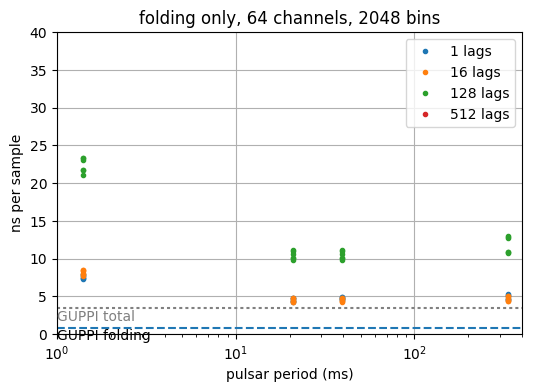

In [36]:
for k,group in ng.groupby(ng.num_lags):
    semilogx(1e3*group.samples_per_bin*group.num_bins/(800e6/512.),group.ns_per_sample,'.',label=('%d lags' % k))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
add_guppi_lines()
legend(loc='upper right')
xlabel('pulsar period (ms)')
xlim(1,400)
ylabel('ns per sample')
title('folding only, 64 channels, 2048 bins')
grid()
ylim(0,40)

(0, 40)

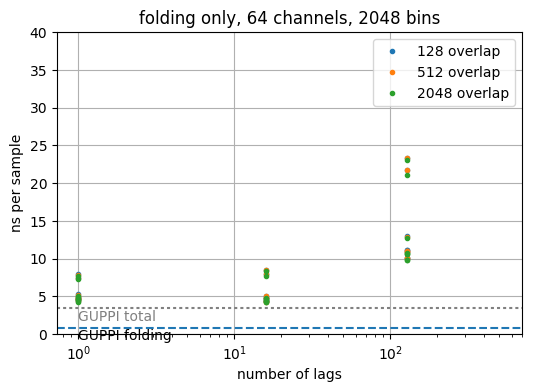

In [38]:
for k,group in ng.groupby(ng.overlap):
    semilogx(group.num_lags,group.ns_per_sample,'.',label=('%d overlap' % k))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
add_guppi_lines()
legend(loc='upper right')
xlabel('number of lags')
#xlim(1,400)
ylabel('ns per sample')
title('folding only, 64 channels, 2048 bins')
grid()
ylim(0,40)

In [50]:
rcParams['font.size']=16

(0.5, 110)

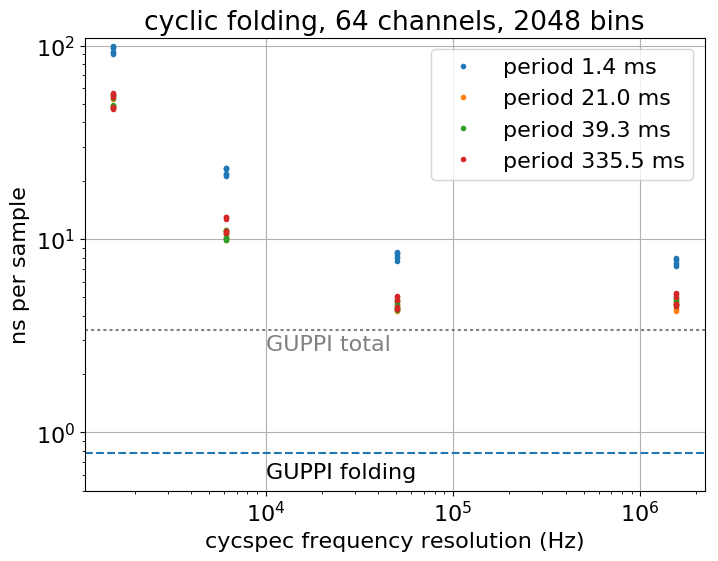

In [53]:
figure(figsize=(8,6))
for k,group in ng.groupby(ng.samples_per_bin):
    semilogx((800e6/512)/(group.num_lags*2-1),group.ns_per_sample,'.',label=('period %.1f ms' % (1e3*k*2048/(800e6/512))))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
add_guppi_lines(x=1e4)
legend(loc='upper right')
xlabel('cycspec frequency resolution (Hz)')
#xlim(1,400)
ylabel('ns per sample')
title('cyclic folding, 64 channels, 2048 bins')
grid()
yscale('log')
#axhline((0.036+0.720+0.026),linestyle='--')
#axhline(3.4,linestyle=':',color='gray')
ylim(.5,110)

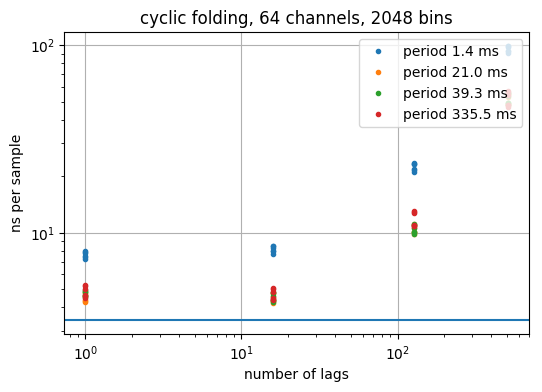

In [42]:
for k,group in ng.groupby(ng.samples_per_bin):
    semilogx(group.num_lags,group.ns_per_sample,'.',label=('period %.1f ms' % (1e3*k*2048/(800e6/512))))
#axhline((0.036+0.720+0.026))
#axhline(3.4,linestyle=':',color='gray')
#add_guppi_lines()
legend(loc='upper right')
xlabel('number of lags')
#xlim(1,400)
ylabel('ns per sample')
title('cyclic folding, 64 channels, 2048 bins')
grid()
yscale('log')
axhline(3.4)
#ylim(0,40)

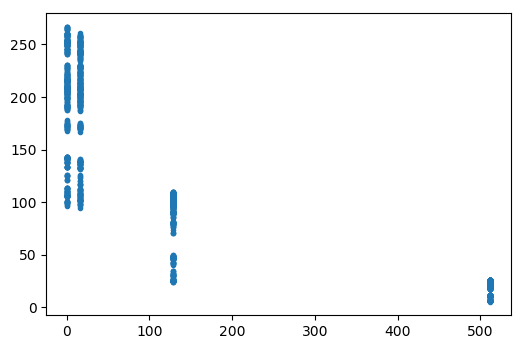

In [7]:
plot(results.num_lags,1e-6*(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

In [8]:
results.to_hdf('2017-06-07-multichannel-results.h5','results')

In [11]:
import time
filename = time.strftime('%Y-%m-%d_%H%M%S_multichannel_results.h5')

In [12]:
filename

'2017-06-14_094758_multichannel_results.h5'

In [11]:
r2 = pd.read_hdf('2017-06-07-multichannel-results.h5',key='results')

In [15]:
2**27/8/2

8388608

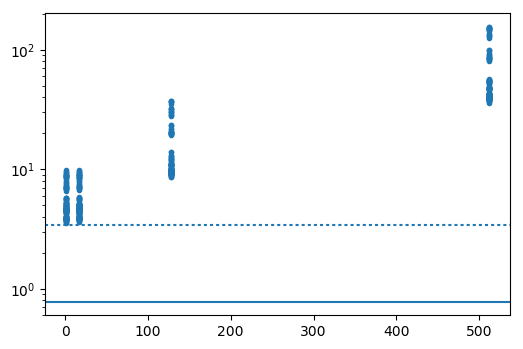

In [11]:
semilogy(ng.num_lags,ng.ns_per_sample,'.')
axhline((0.036+0.720+0.026))
axhline(3.4,linestyle=':')

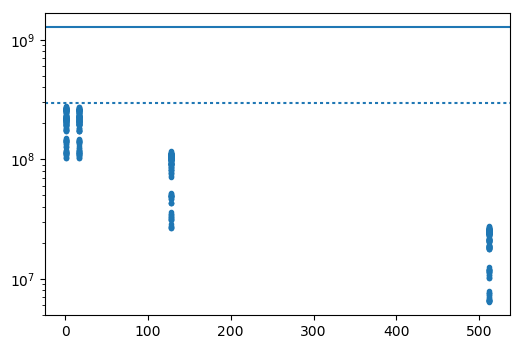

In [12]:
semilogy(ng.num_lags,1e9/ng.ns_per_sample,'.')
axhline(1e9/(0.036+0.720+0.026))
axhline(1e9/(3.4),linestyle=':')


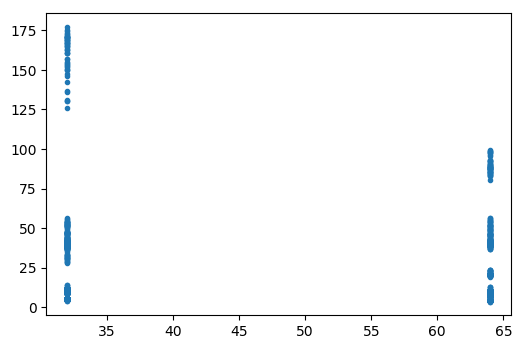

In [15]:
plot(results.max_registers,results.ns_per_sample,'.')

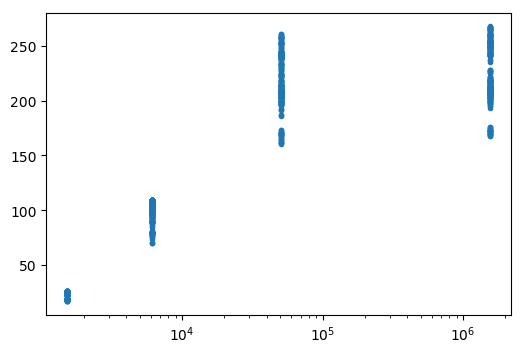

In [8]:
semilogx((800e6/512)/(2*(results.num_lags-1)+1),1e-6*(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

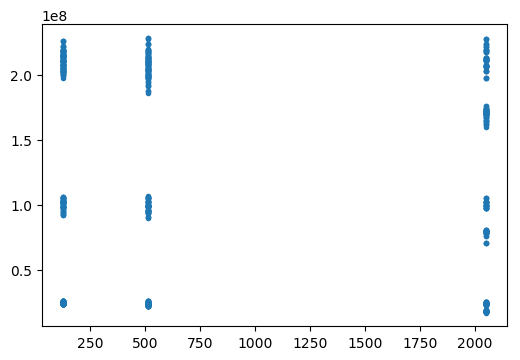

In [36]:
plot(results.num_bins,(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

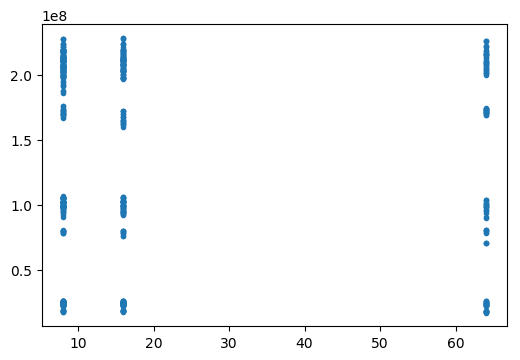

In [37]:
plot(results.num_channels,(results.num_channels*results.num_fft*(results.fft_len-results.overlap))/(results.elapsed*1e-3),'.')

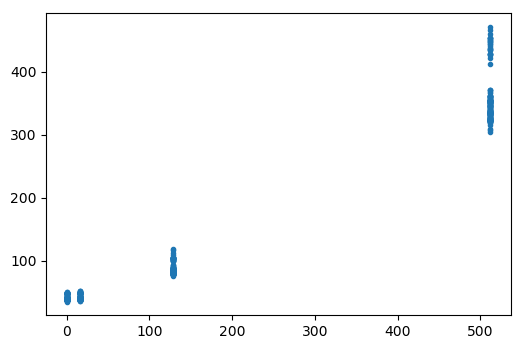

In [38]:
plot(results.num_lags,results.elapsed,'.')

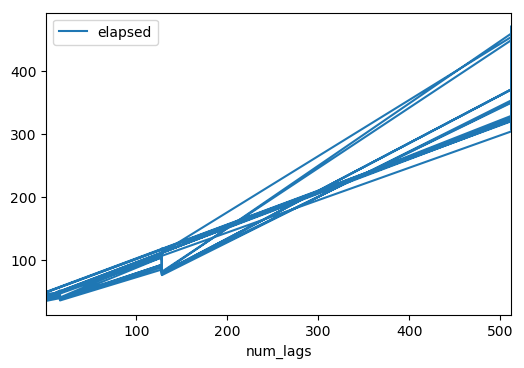

In [39]:
results.plot('num_lags','elapsed')

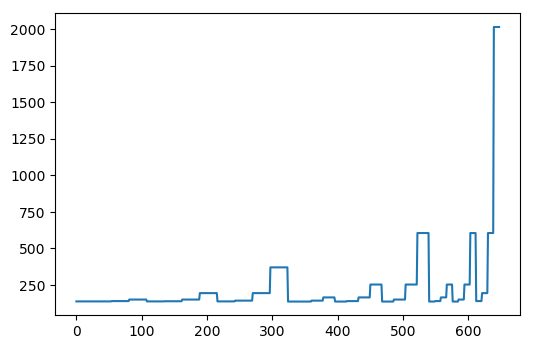

In [40]:
plot(results.mem_used/1e6)